In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math as mth


def Ux1(t, a=1):
    return np.exp(-a * t)


def Ux2(t, a=1):
    return -np.exp(-a * t)


def U(x):
    return np.sin(x)


def Analitic(x, t, a=1):
    return np.exp(-a * t) * np.sin(x)


def progonka(a, b, c, d, s):
    P = np.zeros(s)
    Q = np.zeros(s)

    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]

    k = s - 1

    for i in range(1, s):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[k] = 0
    Q[k] = (d[k] - a[k] * Q[k - 1]) / (b[k] + a[k] * P[k - 1])

    x = np.zeros(s)
    x[k] = Q[k]

    for i in range(s - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

def autofill(x0, space_step, m, n):
    Uarray = np.zeros([n, m])

    tmp_x = x0
    for j in range(m):
        Uarray[0][j] = U(tmp_x)
        tmp_x += space_step

    return Uarray


def explicit(param_t, param_a, space_step, time_step, m, n, aprox, ans_time):
    x0 = 0
    xl = mth.pi

    X = np.arange(x0, xl + space_step, space_step)

    Uarray = autofill(x0, space_step, m, n)

    sigma = param_a**2 * time_step / space_step**2

    tmp_time = 0
    for k in range(1, n):
        for j in range(1, m - 1):
            Uarray[k][j] = sigma * \
                (Uarray[k - 1][j + 1] + Uarray[k - 1][j - 1]) + \
                (1 - 2 * sigma) * Uarray[k - 1][j]
        if aprox == 1:
            Uarray[k][0] = Uarray[k][1] - space_step * Ux1(tmp_time, param_a)
            Uarray[k][m - 1] = Uarray[k][m - 2] + \
                space_step * Ux2(tmp_time, param_a)
        elif aprox == 2:
            Uarray[k][0] = (Ux1(tmp_time, param_a) +
                            Uarray[k][2] / (2 * space_step) -
                            2 * Uarray[k][1] / space_step) * \
                ((2 * space_step) / -3)
            Uarray[k][m - 1] = (Ux2(tmp_time, param_a) -
                                Uarray[k][m - 3] / (2 * space_step) +
                                2 * Uarray[k][m - 2] / space_step) * \
                ((2 * space_step) / 3)
        elif aprox == 3:
            Uarray[k][0] = (Uarray[k][1] -
                            space_step * Ux1(tmp_time, param_a) +
                            (space_step**2 / 2 / time_step) *
                            Uarray[k - 1][0]) / \
                (1 + space_step**2 / 2 / time_step)
            Uarray[k][m - 1] = (Uarray[k][m - 2] +
                                space_step * Ux2(tmp_time, param_a) +
                                (space_step**2 / 2 / time_step) *
                                Uarray[k - 1][m - 1]) / \
                (1 + space_step**2 / 2 / time_step)

        tmp_time += time_step

    in_array = int(ans_time / time_step)
    ans_t = in_array * time_step
    max_analitic_in_it_time = []
    T = np.arange(0, param_t + time_step, time_step)
    for k in T:
        in_it_time = Analitic(X, k)
        in_arr = int(k / time_step)
        max_analitic_in_it_time.append(max(abs(in_it_time - Uarray[in_arr])))
    return Analitic(X, ans_t), Uarray[in_array], max_analitic_in_it_time



def implicit(param_t, param_a, space_step, time_step, m, n, aprox, ans_time):
    x0 = 0
    xl = mth.pi

    X = np.arange(x0, xl + space_step, space_step)

    Uarray = autofill(x0, space_step, m, n)

    sigma = param_a**2 * time_step / space_step**2

    for k in range(n - 1):
        a = np.zeros(m)
        b = np.zeros(m)
        c = np.zeros(m)
        d = np.zeros(m)

        for j in range(1, m - 1):
            a[j] = sigma
            b[j] = -(1 + 2 * sigma)
            c[j] = sigma
            d[j] = -Uarray[k][j]
        if aprox == 1:
            b[0] = -1 / space_step
            c[0] = 1 / space_step
            d[0] = Ux1((k + 1) * time_step)

            a[m - 1] = -1 / space_step
            b[m - 1] = 1 / space_step
            d[m - 1] = Ux2((k + 1) * time_step)
        elif aprox == 2:
            k0 = 1 / (2 * space_step) / c[1]
            b[0] = (-3 / (space_step * 2)) + a[1] * k0
            c[0] = 2 / space_step + b[1] * k0
            d[0] = Ux1((k + 1) * time_step) + d[1] * k0

            k1 = -(1 / (space_step * 2)) / a[m - 2]
            a[m - 1] = (-2 / space_step) + b[m - 2] * k1
            b[m - 1] = (3 / (space_step * 2)) + c[m - 2] * k1
            d[m - 1] = Ux2((k + 1) * time_step) + d[m - 2] * k1
        elif aprox == 3:
            b[0] = 2 * param_a**2 / space_step + space_step / time_step
            c[0] = - 2 * param_a**2 / space_step
            d[0] = (space_step / time_step) * Uarray[k - 1][0] - \
                Ux1((k + 1) * time_step) * 2 * param_a**2

            a[m - 1] = -2 * param_a**2 / space_step
            b[m - 1] = 2 * param_a**2 / space_step + space_step / time_step
            d[m - 1] = (space_step / time_step) * Uarray[k - 1][m - 1] + \
                Ux2((k + 1) * time_step) * 2 * param_a**2

        Y = progonka(a, b, c, d, m)
        Uarray[k + 1] = Y

    in_array = int(ans_time / time_step)
    ans_t = in_array * time_step
    max_analitic_in_it_time = []
    T = np.arange(0, param_t + time_step, time_step)
    for k in T:
        in_it_time = Analitic(X, k)
        in_arr = int(k / time_step)
        max_analitic_in_it_time.append(max(abs(in_it_time - Uarray[in_arr])))
    return Analitic(X, ans_t), Uarray[in_array], max_analitic_in_it_time


def KN(param_t, param_a, space_step, time_step, m, n, aprox, ans_time):
    x0 = 0
    xl = mth.pi

    X = np.arange(x0, xl + space_step, space_step)

    Uarray = autofill(x0, space_step, m, n)

    sigma = param_a**2 * time_step / space_step**2

    for k in range(n - 1):
        a = np.zeros(m)
        b = np.zeros(m)
        c = np.zeros(m)
        d = np.zeros(m)
        for j in range(1, m - 1):
            a[j] = -sigma / 2
            b[j] = (1 + sigma)
            c[j] = -sigma / 2
            d[j] = (sigma / 2 * Uarray[k][j + 1] + (1 - sigma) *
                    Uarray[k][j] + (sigma / 2) * Uarray[k][j - 1])
        if aprox == 1:
            b[0] = -1 / space_step
            c[0] = 1 / space_step
            d[0] = Ux1((k + 1) * time_step)
            a[m - 1] = -1 / space_step
            b[m - 1] = 1 / space_step
            d[m - 1] = Ux2((k + 1) * time_step)
        if aprox == 2:
            k0 = 1 / (2 * space_step) / c[1]
            b[0] = (-3 / (space_step * 2)) + a[1] * k0
            c[0] = 2 / space_step + b[1] * k0
            d[0] = Ux1((k + 1) * time_step) + d[1] * k0

            k1 = -(1 / (space_step * 2)) / a[m - 2]
            a[m - 1] = (-2 / space_step) + b[m - 2] * k1
            b[m - 1] = (3 / (space_step * 2)) + c[m - 2] * k1
            d[m - 1] = Ux2((k + 1) * time_step) + d[m - 2] * k1
        elif aprox == 3:
            b[0] = 2 * param_a**2 / space_step + space_step / time_step
            c[0] = - 2 * param_a**2 / space_step
            d[0] = (space_step / time_step) * Uarray[k - 1][0] - \
                Ux1((k + 1) * time_step) * 2 * param_a**2

            a[m - 1] = -2 * param_a**2 / space_step
            b[m - 1] = 2 * param_a**2 / space_step + space_step / time_step
            d[m - 1] = (space_step / time_step) * Uarray[k - 1][m - 1] + \
                Ux2((k + 1) * time_step) * 2 * param_a**2

        Y = progonka(a, b, c, d, m)
        Uarray[k + 1] = Y

    in_array = int(ans_time / time_step)
    ans_t = in_array * time_step

    max_analitic_in_it_time = []
    T = np.arange(0, param_t + time_step, time_step)
    for k in T:
        in_it_time = Analitic(X, k)
        in_arr = int(k / time_step)
        max_analitic_in_it_time.append(max(abs(in_it_time - Uarray[in_arr])))
    return Analitic(X, ans_t), Uarray[in_array], max_analitic_in_it_time
n = 21000


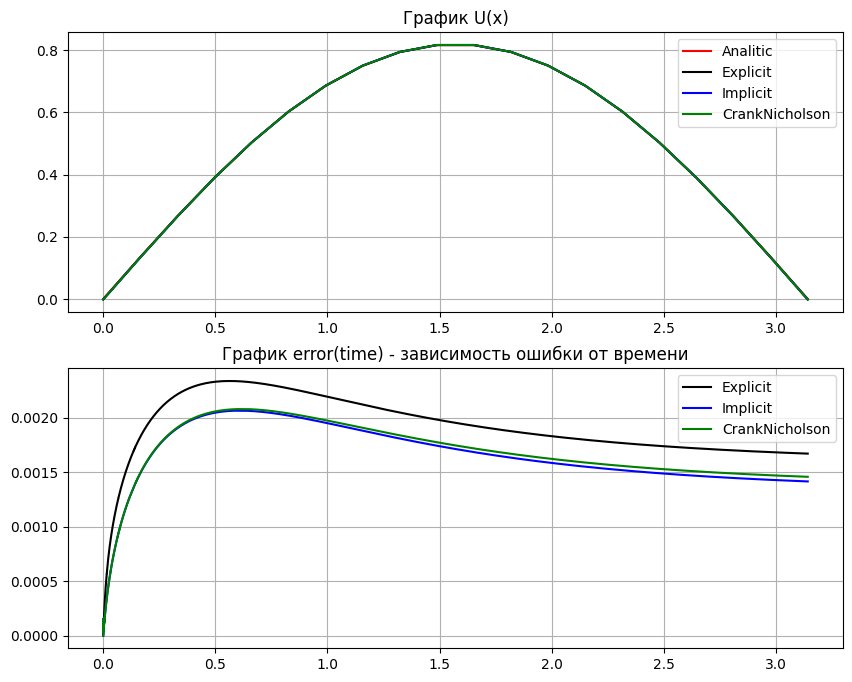

In [7]:
x0 = 0.0
xl = mth.pi

# from 0.1 to 10
param_t = float(mth.pi)
# from 0.1 to 10
param_a = float(1.0)
# число интервалов по Х from 5 to 50
m = 20
# число интервалов по Т from 5 to 50
t = 21
# u"Двухточечный(первый порядок)", u"Трехточечный(второй порядок)", u"Двухточечный(второй порядок)
apr = u"Двухточечный(второй порядок)"
# момент времени from 0, to 10
ans_t = float(0.2)
aprox = 0

space_step = (xl - x0) / (m - 1)
time_step = param_t / (n - 1)

if param_a < 0:
    note = 'Ошибка!\nПараметр "а" должен быть больше 0!'
    exit()
elif param_t < 0:
    note = 'Ошибка!\nПараметр "t" должен быть больше 0!'
    exit()
elif ans_t > param_t:
    note = 'Ошибка!\nПараметр момент времени должен быть меньше "t"!'
    exit()
elif param_a**2 * time_step / space_step**2 > 0.5:
    note = 'Ошибка!\nПри таких мараметрах Явный метод не устойчив!\n\
    Пожалуйста, измените параметры сетки.'
    exit()
if apr == 'Двухточечный(первый порядок)':
    aprox = 1
elif apr == 'Трехточечный(второй порядок)':
    aprox = 2
elif apr == 'Двухточечный(второй порядок)':
    aprox = 3


data_dict = {}
data_err = {}

data_dict['Analytic'], data_dict['Explicit'], data_err['Explicit'] = explicit(param_t, param_a, space_step,
                time_step, m, n, aprox, ans_t)
_, data_dict['Implicit'], data_err['Implicit'] = implicit(param_t, param_a, space_step,
                time_step, m, n, aprox, ans_t)
_, data_dict['CrankNicholson'], data_err['CrankNicholson'] = KN(param_t, param_a, space_step,
            time_step, m, n, aprox, ans_t)

X = np.arange(x0, xl + space_step, space_step)
T = np.arange(0, param_t + time_step, time_step)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].set_title('График U(x)')
axs[0].plot(X, data_dict['Analytic'], color='red', label="Analitic")
axs[0].plot(X, data_dict['Explicit'], color='black', label="Explicit")
axs[0].plot(X, data_dict['Implicit'], color='blue', label="Implicit")
axs[0].plot(X, data_dict['CrankNicholson'], color='green', label="CrankNicholson")
axs[0].grid()
axs[0].legend()

axs[1].set_title('График error(time) - зависимость ошибки от времени')
axs[1].plot(T, data_err['Explicit'], color='black', label="Explicit")
axs[1].plot(T, data_err['Implicit'], color='blue', label="Implicit")
axs[1].plot(T, data_err['CrankNicholson'], color='green', label="CrankNicholson")
axs[1].grid()
axs[1].legend()
plt.show()
